In this notebook i wanted to apply a Neural Network Architecture for Regression for a tabular dataset. 
we can review literature to get an idea how to approach fitting a NN to a structured dataset.

 - Tabular problems often do not require very deep networks; many successful models use 1–3 hidden layers.
- A simple ResNet-like multilayer perceptron (MLP) with a few hidden layers can serve as a strong baseline.
- Gorishniy et al. (2021) recommend a 3–4 layer MLP with skip connections as an effective starting point for tabular data.
- Excessive depth can lead to overfitting on limited data.
- Very deep networks can work if they are heavily regularized.
- One study used a 9-layer, 512-neurons-per-layer MLP with modern regularization to outperform gradient boosting on many tabular datasets.
- Large architectures demand careful tuning and robust regularization.
- **The Idea here is to seperate the sections of the pipeline so that we can refine and measure at each iteration**


This pipeline performs a complete end-to-end process for training a neural network regression model on housing data.
First, it identifies the numeric and categorical features from the training dataset and constructs two separate preprocessing
pipelines. The numeric pipeline imputes missing values using the median, applies a quantile-based clipping to limit outliers, 
transforms the data using a logarithmic function (np.log1p) to compress the feature range, and then scales the data with a 
RobustScaler. In parallel, the categorical pipeline imputes missing values with a constant value and one-hot encodes the 
categorical features, ensuring consistent output by precomputing the full list of categories. Both pipelines are then 
combined using a ColumnTransformer. Next, the processed features are fed into a funnel-shaped neural network built with
SciKeras’ KerasRegressor, which consists of three hidden Dense layers (with 128, 64, and 32 neurons, respectively) 
followed by a single output neuron. The network is compiled with the Adam optimizer and Huber loss for robustness a
gainst outliers, and a custom callback logs training progress every 10 epochs. A target transformer is also applied 
so that the target variable is log-transformed during training and inverted during prediction. After fitting the complete 
pipeline on the training data, diagnostic summaries (including training loss trends, decile analysis of predicted versus
actual values, and residual statistics) are generated and visualized through multiple plots. Finally, the pipeline’s 
performance is further evaluated via 5-fold cross-validation, where negative mean absolute error scores are computed 
and converted to positive values, providing an estimate of the model’s generalization error.


In [ ]:
#!pip install scikeras --upgrade
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler, FunctionTransformer)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from scikeras.wrappers import KerasRegressor

In [75]:
# =================================
# DATA LOADING
# =================================
print("\n=== Listing all files in '/kaggle/input' directory ===")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print("Found file:", file_path)

# Define file paths for the training and test CSV files
train_path = "/kaggle/input/home-data-for-ml-course/train.csv"
test_path  = "/kaggle/input/home-data-for-ml-course/test.csv"

print("\n=== Loading Training Data ===")
print("Reading file from:", train_path)
df_train = pd.read_csv(train_path)
print("Training Data loaded successfully!")
print("Training Data Shape:", df_train.shape) 

print("\n=== Loading Test Data ===")
print("Reading file from:", test_path)
df_test = pd.read_csv(test_path)
print("Test Data loaded successfully!")
print("Test Data Shape:", df_test.shape) 

print("\n=== Preview of Training Data (first 5 rows) ===")
display(df_train.head())


=== Listing all files in '/kaggle/input' directory ===
Found file: /kaggle/input/home-data-for-ml-course/sample_submission.csv
Found file: /kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
Found file: /kaggle/input/home-data-for-ml-course/train.csv.gz
Found file: /kaggle/input/home-data-for-ml-course/data_description.txt
Found file: /kaggle/input/home-data-for-ml-course/test.csv.gz
Found file: /kaggle/input/home-data-for-ml-course/train.csv
Found file: /kaggle/input/home-data-for-ml-course/test.csv

=== Loading Training Data ===
Reading file from: /kaggle/input/home-data-for-ml-course/train.csv
Training Data loaded successfully!
Training Data Shape: (1460, 81)

=== Loading Test Data ===
Reading file from: /kaggle/input/home-data-for-ml-course/test.csv
Test Data loaded successfully!
Test Data Shape: (1459, 80)

=== Preview of Training Data (first 5 rows) ===


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [67]:
# SEPARATE FEATURES & TARGET 

print("Creating training feature matrix (X) by dropping 'Id' and 'SalePrice', and target vector (y) from 'SalePrice'...\n")
X = df_train.drop(['Id', 'SalePrice'], axis=1)
y = df_train['SalePrice']

print("Creating test feature matrix (X_test) by dropping 'Id' and extracting test IDs for submission...")
X_test = df_test.drop(['Id'], axis=1)
test_ids = df_test['Id']


Creating training feature matrix (X) by dropping 'Id' and 'SalePrice', and target vector (y) from 'SalePrice'...

Creating test feature matrix (X_test) by dropping 'Id' and extracting test IDs for submission...


# Summary of Preprocessing Pipeline

This describes the steps taken in our preprocessing pipeline to prepare the training data for a neural network model.
 

## 1. Feature Identification

- **Numeric Features:**  
  We extract all columns with data types `int64` and `float64` from the DataFrame `X`. These features are assumed to be continuous and will undergo imputation, transformation, and scaling.

- **Categorical Features:**  
  We identify all columns with the data type `object` in `X`. These features represent categorical data and will be imputed and one-hot encoded.
 

## 2. Numeric Pipeline Construction

The numeric pipeline processes continuous features through several steps to ensure the data is clean, well-scaled, and appropriately transformed for model training. Each step has a specific purpose:

- **Imputation (Median):**
  - **What:** Use `SimpleImputer` with the median strategy to fill in missing values.
  - **Why:**  
    - Missing values can disrupt statistical calculations and model training.
    - The median is robust to outliers, preserving the central tendency of the feature without being overly influenced by extreme values.
  
- **Clipping:**
  - **What:** Apply a custom clipping function (using `np.clip`) to cap extreme values at a defined threshold (e.g., 1e6).
  - **Why:**  
    - Extreme outliers can cause numerical instability during subsequent operations, such as variance computation in scaling.
    - **Variance Computation in Scaling:**  
      Scaling methods, like those used in `StandardScaler` or even in parts of `RobustScaler`, calculate statistical measures such as the variance of each feature. Variance is computed by averaging the squared differences from the mean. When a feature contains very large values, squaring these numbers can result in extremely high values that exceed the limits of floating-point representation, leading to overflow issues. By clipping these values, we restrict the upper bound, preventing them from disproportionately affecting the variance and, ultimately, the scaling process.
    - This step helps maintain numerical stability and ensures that the calculated scaling parameters (like standard deviation or interquartile range) are not skewed by a few extreme values.
  
- **Log Transformation:**
  - **What:** Apply a log transformation using `np.log1p` to compress the range of the data.
  - **Why:**  
    - Many numeric features have a heavy right tail (i.e., a few extremely high values) that makes the distribution skewed.
    - Taking the logarithm reduces skewness and stabilizes variance, making the feature distribution closer to normal, which is beneficial for many machine learning models.
  
- **Scaling (RobustScaler):**
  - **What:** Scale the data using `RobustScaler`.
  - **Why:**  
    - RobustScaler scales features using statistics that are robust to outliers (i.e., the median and interquartile range).
    - This ensures that even if some extreme values remain after clipping and transformation, they do not unduly influence the scale of the data.
 

## 3. Categorical Pipeline Construction

- **Imputation:**  
  - Missing categorical values are filled using `SimpleImputer` with a constant value (e.g., `'missing'`).

- **Encoding:**  
  - We apply `OneHotEncoder` (with `handle_unknown='ignore'`) to convert categorical features into a binary matrix format, enabling the neural network to process them.
 

## 4. Integration with ColumnTransformer

- The numeric and categorical pipelines are combined using a `ColumnTransformer`.  
- **Key Points:**  
  - Each transformer is applied to its respective set of columns.  
  - Any columns not specified in the transformers are dropped (`remainder='drop'`).

 

## 5. Outcome and Final Setup

- **Fitting and Transforming:**  
  - The `ColumnTransformer` is first fitted to `X` and then transforms the data into a new feature set (`processed_X`).

- **Determining the Input Shape:**  
  - The number of features after preprocessing (`n_features`) is computed from `processed_X.shape[1]`.  
  This value is used to define the `input_shape` for the neural network model.
 

**Overall, this preprocessing pipeline ensures that:**

- Missing values are appropriately handled.
- Extreme and highly skewed numeric values are moderated through clipping and log transformation.
- Categorical variables are converted into a machine-readable one-hot encoded format.
- The resulting feature set is well-prepared for effective neural network training.

This comprehensive approach addresses common issues in structured data and provides a robust starting point for building predictive models.


In [68]:
# ===============================
# 1. PREPROCESSING SETUP
# ===============================
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, OneHotEncoder
import os

# Assume X and y are already defined from your training data (e.g., X = df_train.drop(['Id', 'SalePrice'], axis=1) and y = df_train['SalePrice'])
# Also assume df_train and df_test are loaded.

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))

# Define a quantile-based clipping function to handle outliers adaptively
def clip_quantile(X, lower_quantile=0.01, upper_quantile=0.99):
    # Compute lower and upper bounds for each feature (column-wise)
    lower = np.nanpercentile(X, lower_quantile * 100, axis=0)
    upper = np.nanpercentile(X, upper_quantile * 100, axis=0)
    # Clip each column by its own bounds
    return np.clip(X, lower, upper)

# Create a FunctionTransformer for quantile-based clipping
clip_transformer_quantile = FunctionTransformer(clip_quantile)

# Define a log transformer for strictly positive features (using np.log1p)
log_transformer = FunctionTransformer(np.log1p)

# Build a transformer for numeric data:
# 1. Impute missing values with the median.
# 2. Clip extreme values based on each feature's 1st and 99th percentiles.
# 3. Apply a log transformation to compress the range.
# 4. Scale the data using RobustScaler.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('clip', clip_transformer_quantile),
    ('log', log_transformer),
    ('scaler', RobustScaler())
])

# Build a transformer for categorical data:
# 1. Impute missing values with a constant (e.g., 'missing').
# 2. One-hot encode the categorical features.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numeric and categorical transformers into a ColumnTransformer.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Fit and transform the training features.
preprocessor.fit(X)
processed_X = preprocessor.transform(X)
n_features = processed_X.shape[1]
input_shape = (n_features,)
print(f"\nTotal number of features after preprocessing: {n_features}")

Numeric features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
Categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 

The code begins by importing TensorFlow (and its Keras API), SciKeras’s wrapper for Keras models, and other necessary modules from scikit-learn, such as the FunctionTransformer. This setup ensures that we have all the components needed to build, compile, and integrate a neural network model into a scikit-learn pipeline. The FunctionTransformer is especially useful here as it allows us to transform the target variable easily during training and then invert the transformation during prediction.

Next, the model-building function `build_model` is defined. This function constructs a funnel-shaped neural network using TensorFlow’s Sequential API. The network starts with an input layer defined by the provided `input_shape`, then passes through three Dense layers with 128, 64, and 32 units respectively, each activated by the ReLU function. This funnel shape helps the network to gradually compress and extract useful features from the input data. The final Dense layer has one unit, which produces the regression output. The model is compiled using the Adam optimizer and Huber loss, with Huber loss chosen for its robustness to outliers—a common issue in regression problems with real-world data.

A temporary instance of the model is built by calling `build_model` with the appropriate `input_shape`, and its summary is printed. This step serves as a quick check to ensure that the model architecture is correct and provides an overview of the layers and parameters before the model is integrated into the full pipeline.

The code then defines a custom callback class, `CustomLogger`, which inherits from TensorFlow’s Callback class. This callback is configured to log training progress every 10 epochs by printing out the training logs (which include metrics such as loss). This periodic logging helps monitor the model’s training process without overwhelming the output with information from every single epoch.

To address the challenge of a wide-ranging target variable (such as sale prices), a target transformer is defined using scikit-learn’s FunctionTransformer. This transformer automatically applies a logarithmic transformation (`np.log1p`) to the target during training and then inverts the transformation (`np.expm1`) when predictions are made. This transformation stabilizes the variance and often improves the model’s ability to learn when the target spans multiple orders of magnitude.

The model-building function is then wrapped using SciKeras’s `KerasRegressor`, which makes the Keras model compatible with scikit-learn’s API. In this wrapper, parameters such as the input shape, number of epochs, batch size, and verbosity are specified. The custom logger callback is also passed in to monitor training progress, and the target transformer is provided so that the target values are automatically transformed during training and reversed during prediction.

Finally, the overall pipeline is constructed by combining the data preprocessor (assumed to be defined earlier and referenced as `preprocessor`) with the neural network regressor. This scikit-learn Pipeline first applies all preprocessing steps to the raw data and then passes the transformed features to the neural network for training and prediction. This integration ensures that data preprocessing and model training are handled as a single, streamlined process, which simplifies both model evaluation and deployment.


In [69]:
# ===============================
# 2. MODEL SETUP WITH SCIKERAS
# ===============================
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import FunctionTransformer

# Define the model-building function
def build_model(*, input_shape, **kwargs):
    """Builds and compiles a funnel-shaped neural network model."""
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Regression output
    ])
    # Compile the model with Huber loss for robustness to outliers.
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    return model

# Build a temporary model instance to print its summary.
temp_model = build_model(input_shape=input_shape)
temp_model.summary()

# Define a custom callback to log training progress every 10 epochs.
class CustomLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: {logs}")

# Define a target transformer to automatically apply log transformation
# during training and invert it during prediction.
target_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

# Wrap the model-building function with SciKeras' KerasRegressor.
keras_regressor = KerasRegressor(
    model=build_model,                   # Pass the callable function.
    model__input_shape=input_shape,      # Supply input_shape to build_model.
    epochs=50,                           # Adjust epochs as needed.
    batch_size=32,                       # Adjust batch size as needed.
    verbose=0,                           # Disable default verbosity.
    callbacks=[CustomLogger()],          # Use our custom callback.
    target_transformer=target_transformer  # Automatically handle target transformation.
)

# Build the overall pipeline: preprocessor followed by the neural network.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('nn', keras_regressor)
])
 

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                     │ (None, 128)                 │          38,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

- **Graph 1: Training Loss Summary**  
  This graph shows the evolution of the training loss (using Huber loss) over the training epochs. It reports the loss at the first epoch, the loss at the last epoch, the total percentage improvement in loss, and the average improvement per epoch. This summary is crucial because it demonstrates whether the model is effectively learning (i.e., converging to a lower loss) throughout the training process.

- **Graph 2: Predicted vs Actual Summary (Decile Analysis)**  
  In this analysis, the dataset is divided into five quantile-based bins based on the actual sale prices. For each bin, the mean, minimum, and maximum actual values are compared to the mean predicted value, along with the mean absolute error. This breakdown is important because it highlights any systematic bias in the model’s predictions across different price ranges—revealing, for instance, if the model consistently overpredicts or underpredicts in certain segments.

- **Graph 3: Residuals Summary**  
  This summary provides key statistics of the residuals, which are the differences between the actual and predicted values. It includes the mean, standard deviation, and the minimum and maximum residuals, as well as the percentage of residuals falling within specified error ranges (such as ±10,000 and ±20,000). Analyzing these statistics is essential to determine if the errors are centered around zero (indicating unbiased predictions) and to assess the overall consistency and reliability of the model’s predictions.

- **Graph 4: Residuals Distribution Quantiles**  
  This graph displays the 0th, 25th, 50th (median), 75th, and 100th percentiles of the residuals, effectively summarizing their distribution. It provides insight into the spread and skewness of the prediction errors, helping to identify outliers and to verify whether the errors are symmetrically distributed around zero. A balanced distribution suggests that the model performs robustly across the range of predicted values.



=== Fitting the Pipeline on Training Data ===
Epoch 10: {'loss': 27448.919921875}
Epoch 20: {'loss': 19301.96484375}
Epoch 30: {'loss': 16132.9462890625}
Epoch 40: {'loss': 14482.4931640625}
Epoch 50: {'loss': 13566.9560546875}

Graph 1: Training Loss Summary
  - First epoch loss: 180876.9531
  - Last epoch loss: 13566.9561
  - Total improvement: 92.50% decrease in loss
  - Average improvement per epoch: 3346.1999

Graph 2: Predicted vs Actual Summary (Decile Analysis)


,Quantile,Mean Actual,Min Actual,Max Actual,Mean Predicted,Mean Abs Error
0,"(34899.999, 124000.0]",100760.701695,34900,124000,103997.859375,9351.313083
1,"(124000.0, 147000.0]",135884.316327,124500,147000,137088.437500,8051.074777
2,"(147000.0, 179280.0]",163442.832753,147400,179200,163811.109375,9256.785415
3,"(179280.0, 230000.0]",201158.600000,179400,230000,201939.031250,12944.936917
4,"(230000.0, 755000.0]",305261.833910,230500,755000,288296.500000,27994.449070


Overall correlation coefficient: 0.9429
Overall R-squared: 0.8890

Graph 3: Residuals Summary
  - Mean of residuals: 2231.5613
  - Standard deviation: 26790.9469
  - Minimum residual: -286282.1875
  - Maximum residual: 338838.3438
  - Percentage of residuals within ±10,000: 59.86%
  - Percentage of residuals within ±20,000: 81.71%

Graph 4: Residuals Distribution Quantiles
  - 0th percentile: -286282.1875
  - 25th percentile: -6334.4785
  - 50th percentile: 1125.8242
  - 75th percentile: 8376.7637
  - 100th percentile: 338838.3438


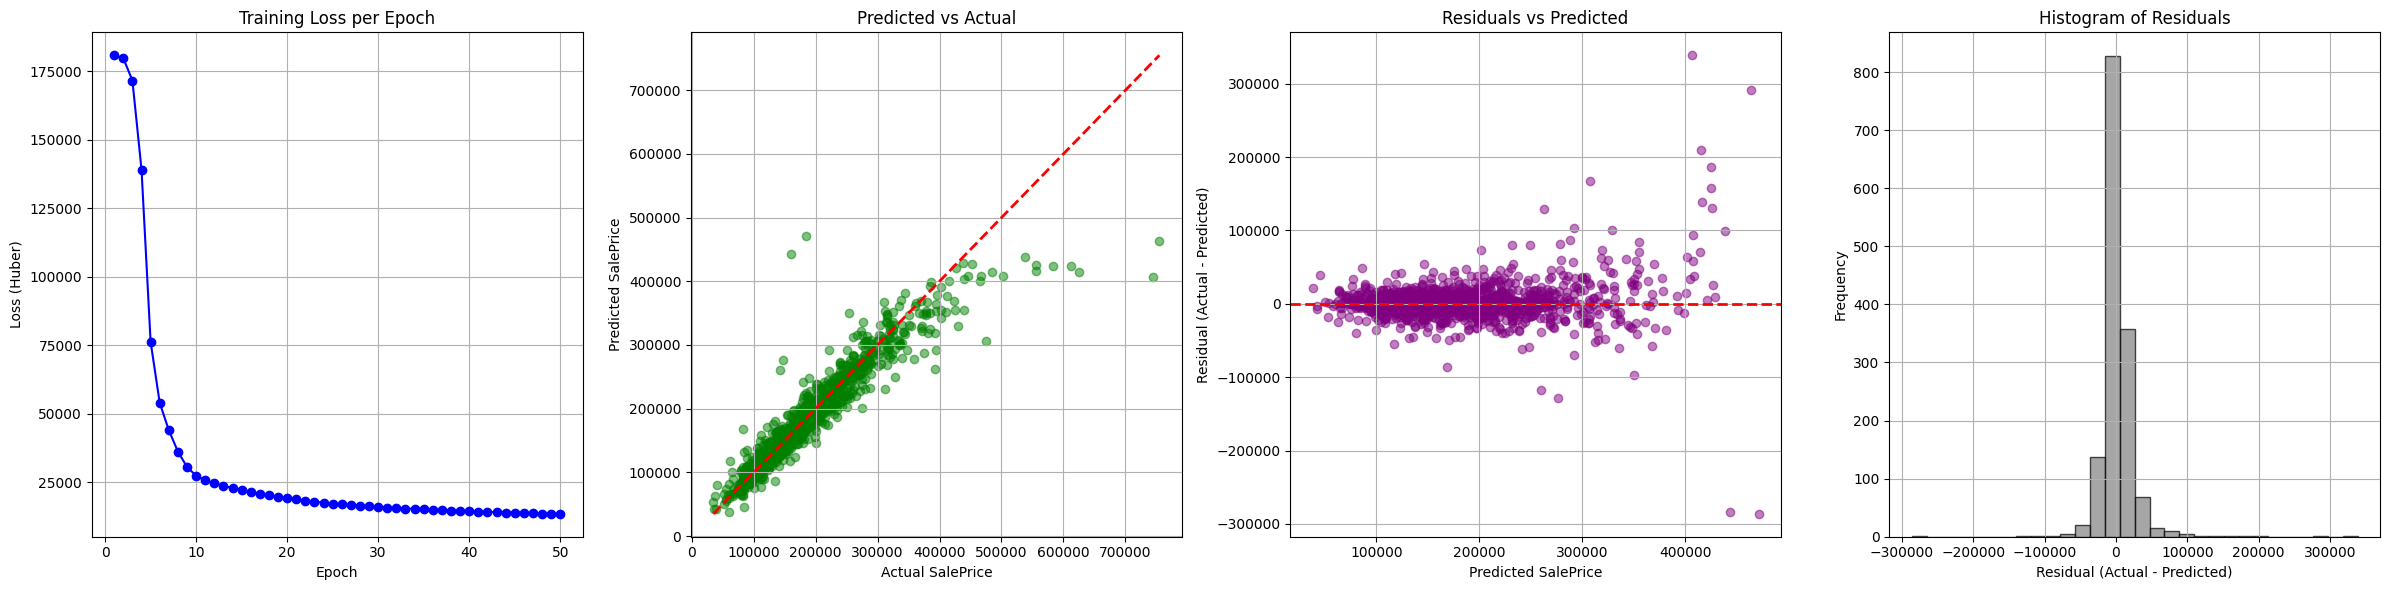

In [74]:

# Fit the pipeline on the training data.
print("\n=== Fitting the Pipeline on Training Data ===")
pipeline.fit(X, y)

# After training, obtain training predictions and diagnostics.
preds_train = pipeline.predict(X)
loss_values = pipeline.named_steps['nn'].history_['loss']
epochs = list(range(1, len(loss_values) + 1))
residuals = y - preds_train

# =============================================================================
# 4. DIAGNOSTIC SUMMARIES AND PLOTS
# =============================================================================
# Graph 1: Training Loss Summary
print("\nGraph 1: Training Loss Summary")
first_epoch_loss = loss_values[0]
last_epoch_loss = loss_values[-1]
improvement_pct = ((first_epoch_loss - last_epoch_loss) / first_epoch_loss) * 100
avg_improvement_per_epoch = (first_epoch_loss - last_epoch_loss) / len(loss_values)
print(f"  - First epoch loss: {first_epoch_loss:.4f}")
print(f"  - Last epoch loss: {last_epoch_loss:.4f}")
print(f"  - Total improvement: {improvement_pct:.2f}% decrease in loss")
print(f"  - Average improvement per epoch: {avg_improvement_per_epoch:.4f}")

# Graph 2: Predicted vs Actual Summary (Decile Analysis)
print("\nGraph 2: Predicted vs Actual Summary (Decile Analysis)")
results_df = pd.DataFrame({
    "Actual": y,
    "Predicted": preds_train,
    "Residual": residuals
})
results_df["Absolute Error"] = results_df["Residual"].abs()
results_df["Quantile"] = pd.qcut(results_df["Actual"], q=5, duplicates="drop")
decile_summary = results_df.groupby("Quantile", observed=False).agg({
    "Actual": ["mean", "min", "max"],
    "Predicted": "mean",
    "Absolute Error": "mean"
}).reset_index()
decile_summary.columns = ["Quantile", "Mean Actual", "Min Actual", "Max Actual", "Mean Predicted", "Mean Abs Error"]
display(decile_summary)

corr_coef = np.corrcoef(y, preds_train)[0, 1]
r_squared = corr_coef ** 2
print(f"Overall correlation coefficient: {corr_coef:.4f}")
print(f"Overall R-squared: {r_squared:.4f}")

# Graph 3: Residuals Summary
print("\nGraph 3: Residuals Summary")
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
min_residual = np.min(residuals)
max_residual = np.max(residuals)
percent_within_10k = np.mean(np.abs(residuals) <= 10000) * 100
percent_within_20k = np.mean(np.abs(residuals) <= 20000) * 100
print(f"  - Mean of residuals: {mean_residual:.4f}")
print(f"  - Standard deviation: {std_residual:.4f}")
print(f"  - Minimum residual: {min_residual:.4f}")
print(f"  - Maximum residual: {max_residual:.4f}")
print(f"  - Percentage of residuals within ±10,000: {percent_within_10k:.2f}%")
print(f"  - Percentage of residuals within ±20,000: {percent_within_20k:.2f}%")

# Graph 4: Residuals Distribution Quantiles
print("\nGraph 4: Residuals Distribution Quantiles")
quantiles = np.percentile(residuals, [0, 25, 50, 75, 100])
print(f"  - 0th percentile: {quantiles[0]:.4f}")
print(f"  - 25th percentile: {quantiles[1]:.4f}")
print(f"  - 50th percentile: {quantiles[2]:.4f}")
print(f"  - 75th percentile: {quantiles[3]:.4f}")
print(f"  - 100th percentile: {quantiles[4]:.4f}")

# -------------------------------
# Plotting: Four Graphs Side by Side
# -------------------------------
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Graph 1: Training Loss per Epoch
axs[0].plot(epochs, loss_values, marker='o', color='blue')
axs[0].set_title('Training Loss per Epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss (Huber)')
axs[0].grid(True)

# Graph 2: Predicted vs Actual Values
axs[1].scatter(y, preds_train, alpha=0.5, color='green')
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axs[1].set_title('Predicted vs Actual')
axs[1].set_xlabel('Actual SalePrice')
axs[1].set_ylabel('Predicted SalePrice')
axs[1].grid(True)

# Graph 3: Residuals vs Predicted
axs[2].scatter(preds_train, residuals, alpha=0.5, color='purple')
axs[2].axhline(0, color='red', linestyle='--', lw=2)
axs[2].set_title('Residuals vs Predicted')
axs[2].set_xlabel('Predicted SalePrice')
axs[2].set_ylabel('Residual (Actual - Predicted)')
axs[2].grid(True)

# Graph 4: Histogram of Residuals
axs[3].hist(residuals, bins=30, color='gray', edgecolor='black', alpha=0.7)
axs[3].set_title('Histogram of Residuals')
axs[3].set_xlabel('Residual (Actual - Predicted)')
axs[3].set_ylabel('Frequency')
axs[3].grid(True)

plt.tight_layout()
plt.show()
